# SimonStrong - Modeling in Reducing Commercial Aviation Fatalities
Hello there! This is team SimonStrong, a group of newbies in Kaggle community from Simon Business School, University of Rochester. 
We are talking about what we have done so far to achieve our progress and are looking for feedbacks for us to improve.

Team members: Yutao Hu(author), Weinan Hu, Jingpeng Ai, Haotian Gong and Yujie Guo.
#### Data Preparation part is based on Starter Code : EDA and LGBM Baseline. Credits to original author Theo Viel.

### Outline
* Preparations
* Exploratory Data Analysis
* Data Cleaning
* Feature Engineering
* Model Training
* Submission

### Preparations
#### Load packages and setup environment. Most of this part is inherited from Theo Viel's work.

In [1]:
import gc
import numpy as np 
import pandas as pd
import lightgbm as lgb
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt


In [2]:
%matplotlib notebook

Designate dtypes for memory efficiency and load data.

In [3]:
dtypes = {"crew": "int8",
          "experiment": "category",
          "time": "float32",
          "seat": "int8",
          "eeg_fp1": "float32",
          "eeg_f7": "float32",
          "eeg_f8": "float32",
          "eeg_t4": "float32",
          "eeg_t6": "float32",
          "eeg_t5": "float32",
          "eeg_t3": "float32",
          "eeg_fp2": "float32",
          "eeg_o1": "float32",
          "eeg_p3": "float32",
          "eeg_pz": "float32",
          "eeg_f3": "float32",
          "eeg_fz": "float32",
          "eeg_f4": "float32",
          "eeg_c4": "float32",
          "eeg_p4": "float32",
          "eeg_poz": "float32",
          "eeg_c3": "float32",
          "eeg_cz": "float32",
          "eeg_o2": "float32",
          "ecg": "float32",
          "r": "float32",
          "gsr": "float32",
          "event": "category",
         }

train_df = pd.read_csv("train.csv", dtype=dtypes)
test_df = pd.read_csv("test.csv", dtype=dtypes)

Let's see how many crews are we dealing with. And see if we have the same folks in test data.

In [4]:
print(train_df.crew.unique())
assert(set(train_df.crew.unique())==set(test_df.crew.unique()))

[ 1  2  3  4  5  6  7  8 13]


Each pilot is identified as occupying one seat (left or right) in one crew (9 crews in total). We generate a unique ID for each pilot.

In [5]:
train_df['pilot'] = 100 * train_df['seat'] + train_df['crew']
test_df['pilot'] = 100 * test_df['seat'] + test_df['crew']
#Add pilots value

### Exploratory Data Analysis
#### In this section, we would like to illustrate our visuals and how we get insights.

We have column 'time' in our data. Let's see if it is organized in a good manner. Take pilot No.1 as an example.

<IPython.core.display.Javascript object>


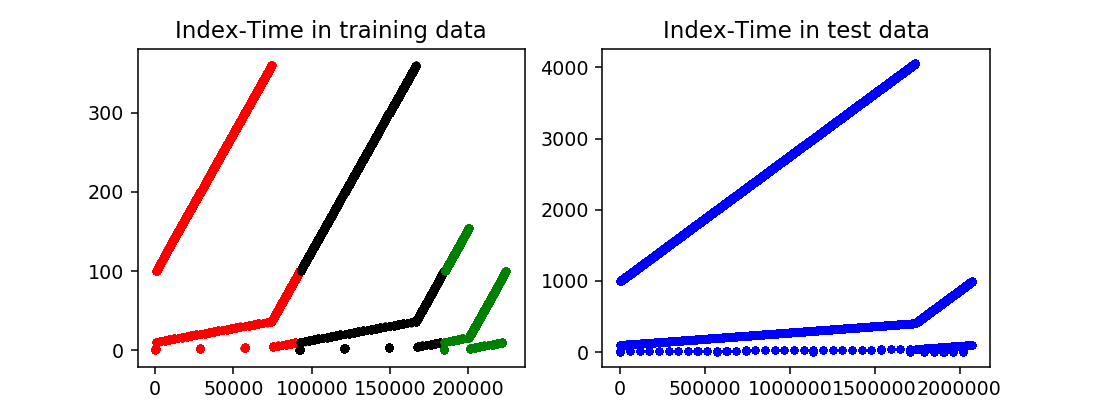

D:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
D:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [6]:
plt.figure(figsize=(8,3))
chunk = train_df[train_df.pilot==1].reset_index()
exp_colors = {'SS':'g','CA':'r','DA':'k','LOFT':'b'}
for exp in chunk.experiment.unique():
    exp_chunk=chunk[chunk.experiment==exp]
    plt.subplot(1,2,1)
    plt.scatter(exp_chunk.index,exp_chunk.time.values,alpha=0.5,marker='.',c=exp_colors[exp])
    plt.title('Index-Time in training data')
    
test_chunk = test_df[test_df.pilot==1]
for exp in test_chunk.experiment.unique():
    exp_chunk=test_chunk[test_chunk.experiment==exp]
    plt.subplot(1,2,2)
    plt.scatter(exp_chunk.index,exp_chunk.time.values,alpha=0.5,marker='.',c=exp_colors[exp])
    plt.title('Index-Time in test data')

Looks like we have a dataset shuffled in terms of time. Also, for each experiment time is recalculated. 3 kinds of experiments in training set and 1 in test set. What about we sort by time and plot again? If we get a perfect line, that means we can restore order of data to do more analysis.

<IPython.core.display.Javascript object>


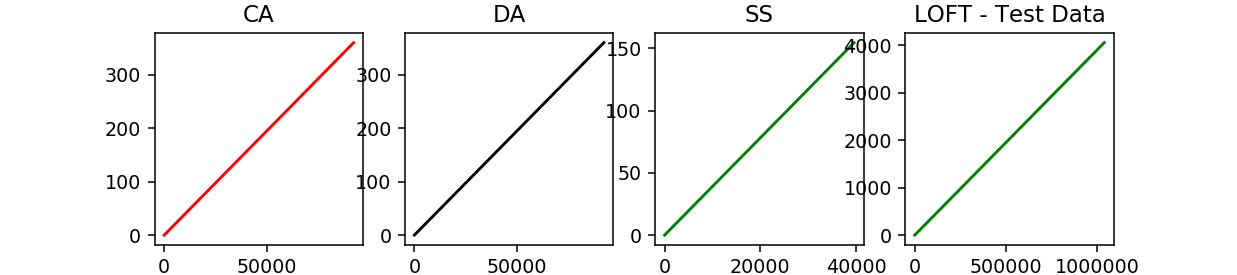

In [7]:
plt.figure(figsize=(9,2))
chunk_sorted = chunk.sort_values(by='time')
for i,exp in enumerate(chunk.experiment.unique()):
    plt.subplot(1,4,i+1)
    exp_chunk=chunk_sorted[chunk_sorted.experiment==exp].reset_index()
    plt.plot(exp_chunk.index,exp_chunk.time,c=exp_colors[exp])
    plt.title(exp)

plt.subplot(1,4,4)
test_chunk = test_chunk.sort_values(by='time').reset_index()
plt.plot(test_chunk.index,test_chunk.time,c=exp_colors[exp])
plt.title('LOFT - Test Data');

As can be seen, after sorting our time data looks perfectly continuous and monotonic. A big progress! Now with this continuous dataframe we can investigate how time interacts with other features. To save space, we show only a few visuals from our collection.

<IPython.core.display.Javascript object>


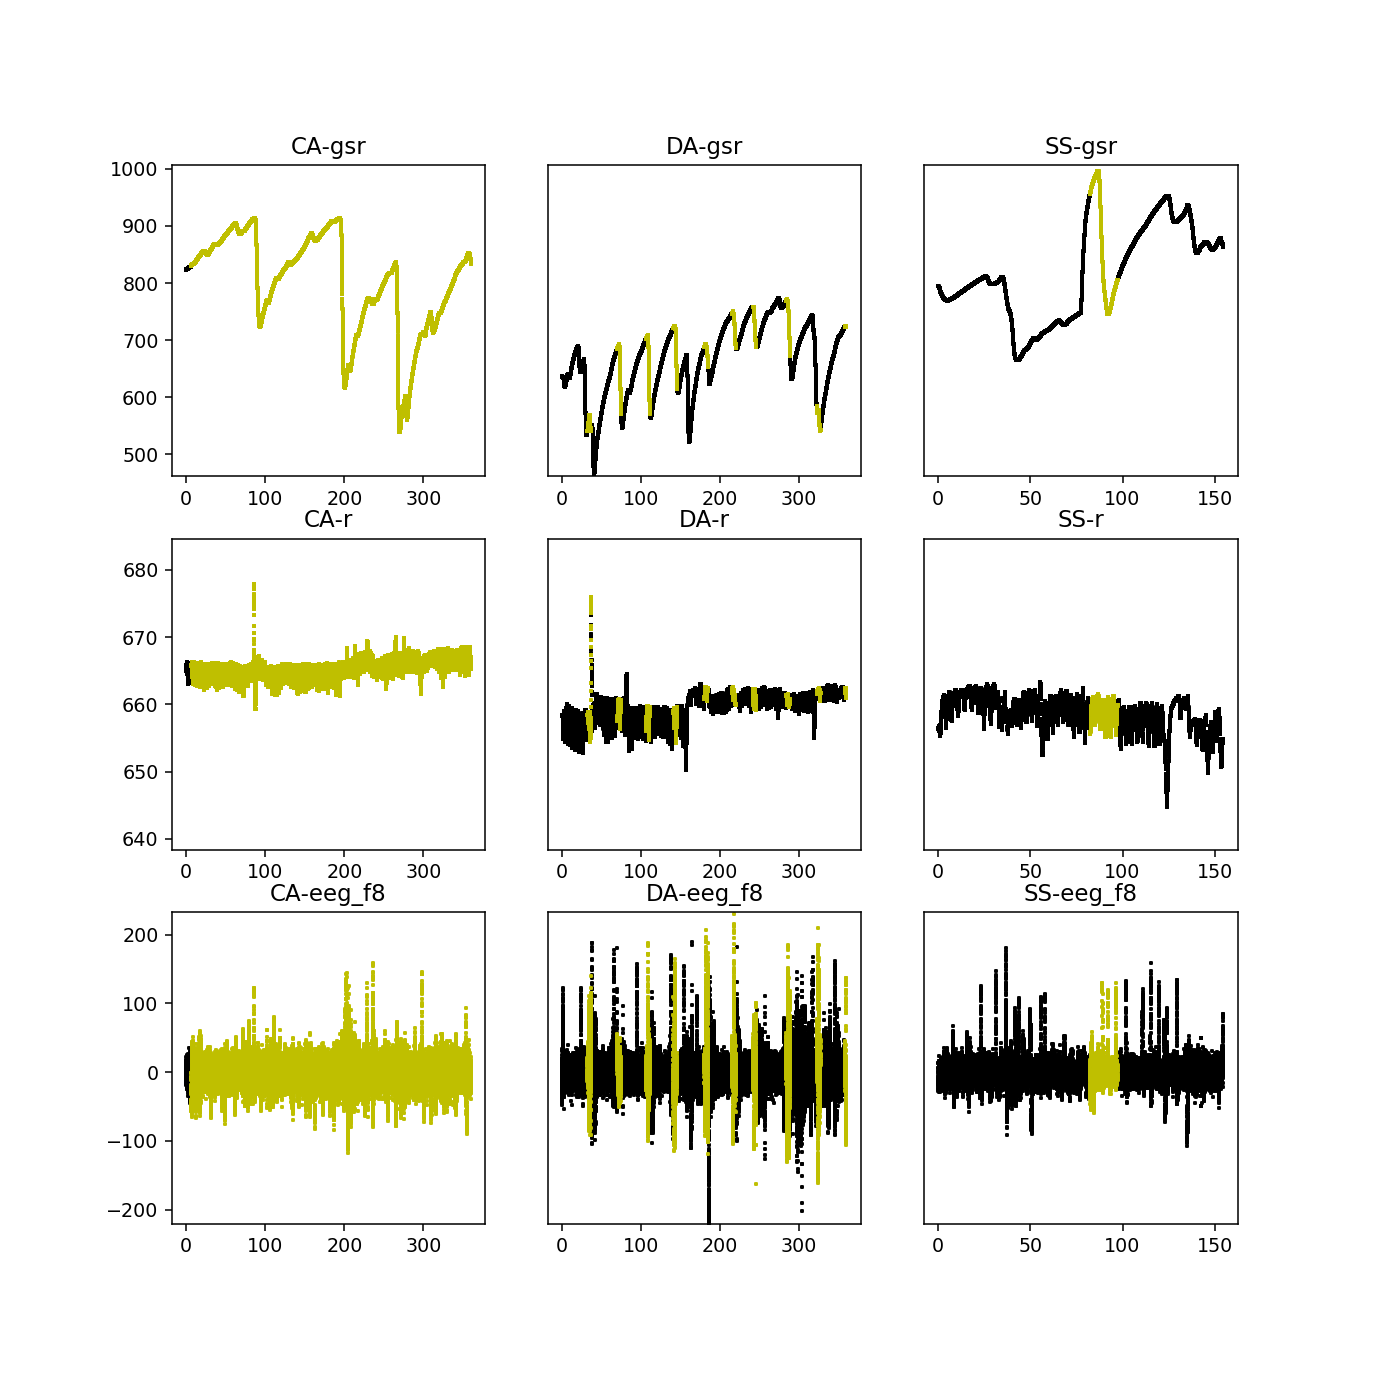

In [8]:
plt.figure(figsize=(10,10)) 
for i,feature in enumerate(['gsr','r','eeg_f8']):
    for j,exp in enumerate(chunk.experiment.unique()):
        plt.subplot(3,3,i*3+j+1)
        exp_chunk = chunk_sorted[chunk_sorted.experiment==exp]
        for event in exp_chunk.event.unique():
            event_chunk = exp_chunk[exp_chunk.event==event]
            plt.scatter(event_chunk.time,event_chunk[feature],c='k' if event=='A' else 'y',marker=',',s=1)

            plt.ylim((chunk[feature].min()*0.99,chunk[feature].max()*1.01))
        plt.title(exp+'-'+feature)
        if j!=0:
            plt.tick_params(
                axis = 'y',       # changes apply to the x-axis
                which = 'both',   # both major and minor ticks are affected
                left = False,     # ticks along the bottom edge are off
                labelleft = False)

We can see that our variables are continuous, changing little in short amount of time. Also, events occur suddenly and last for sometime. Lastly, think of our goal: we are predicting events in a new experiment that our model knows nothing about it. All of these indicate that we need to think of a new way to shuffle data into training and validation dataset. Otherwise, suppose we are using random split over one time period, 80% data in this period goes to training set, and 20% goes to validation set. Because data in two pieces are so similar that our classifier learns how to match training data with validation set instead, we are overwhelmingly overfitting and prediction results using validation dataset can be over-optimistic (this is presumably why we can get a perfect prediction against validation set but final submissions usually disappoint us). 

My way to cope with this situation is to group data according to time. If we split our data into fragments of several seconds, we are reducing correlation between each group and making it harder for our classifier to "match".

I am assigning groups into 60-sec fragments for illustration purpose because the more groups we have, the longer it takes to calculate group features during feature engineering.

In [22]:
def grouping(df):
    print('Grouping data for {} rows'.format(len(df)))
    df['groupid'] = np.nan
    first_available = 0  # Ensure a unique ID for every fragment during one experiment of one pilot in the entire dataframe
    interval = 60        # variable to control inrerval of each group
    for pilot in tqdm(df.pilot.unique()):
        for exp in df[df.pilot==pilot].experiment.unique():
            chunk = df[(df.pilot==pilot) & (df.experiment==exp)]
            df.loc[chunk.index,'groupid'] = (chunk.time//interval).astype(int) + first_available
            first_available+=((int)((chunk.time//interval).max())+1)
grouping(train_df)
grouping(test_df)

Grouping data for 4867421 rows


Grouping data for 17965143 rows


And the code to generate group-level training and validation dataset.

In [10]:
def train_test_split_group(X,y,grouping_reference,random_state=0,train_size=0.75):
    from sklearn.model_selection import train_test_split
    groups = grouping_reference.unique()
    groupN = len(groups)
    Gtrain,Gtest = train_test_split(groups,random_state=random_state,train_size=train_size)
    train_index = sum([list(grouping_reference[grouping_reference==group].index) for group in Gtrain],[])
    test_index = sum([list(grouping_reference[grouping_reference==group].index) for group in Gtest],[])
    X_train = X.loc[train_index]
    y_train = y[train_index]
    X_test = X.loc[test_index]
    y_test = y[test_index]
    return X_train,X_test,y_train,y_test

What about our target variable? What's the distribution of this term?

<IPython.core.display.Javascript object>


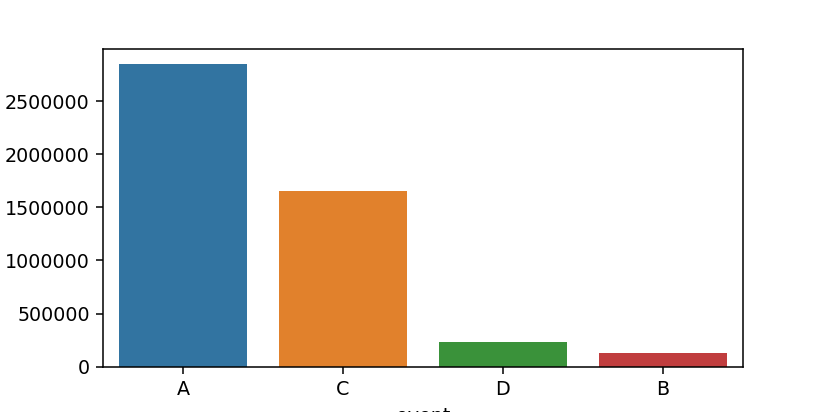

In [11]:
plt.figure(figsize=(6,3))
sns.countplot(train_df.event);

Clearly we have an imbalanced dataset which can impact model performance over minor classes.

### Data Cleaning

Most columns are fine, but gsr (galvanic skin response) is an exception. There are lots of abnormal values in gsr that we should deal with.

<IPython.core.display.Javascript object>


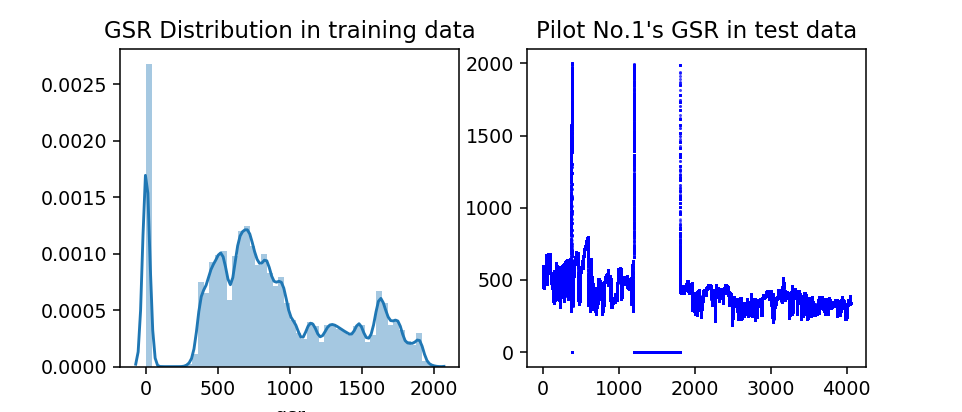

In [12]:
plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
sns.distplot(train_df.gsr)
plt.title('GSR Distribution in training data');
plt.subplot(1,2,2)

example = test_df[test_df.pilot==1].sort_values(by='time').reset_index()
exp_colors = {'SS':'g','CA':'r','DA':'k','LOFT':'b'}
for exp in example.experiment.unique():
    exp_chunk = example[example.experiment==exp]
    plt.scatter(exp_chunk.time,exp_chunk.gsr,alpha=0.5,marker='.',c=exp_colors[exp],s=1)
plt.title('Pilot No.1\'s GSR in test data');

We can observe that there are many zero values in gsr that do not look normal. Also, we can see most values do no change a lot, while at some point values fluctuate drastically. Hence, we should think of RobustScaler to normalize our data.

In [13]:
containsZero = []
for pilot in tqdm(train_df.pilot.unique()):
    for exp in train_df[train_df.pilot==pilot].experiment.unique():
        chunk = train_df[(train_df.pilot==pilot) & (train_df.experiment==exp)]
        if (chunk.gsr==0).any():
            containsZero.append((pilot,exp))
list(map(lambda x:print('Detected zero gsr in Pilot No.{} Experiment:{}'.format(x[0],x[1])),containsZero));


Detected zero gsr in Pilot No.102 Experiment:CA
Detected zero gsr in Pilot No.102 Experiment:DA
Detected zero gsr in Pilot No.102 Experiment:SS
Detected zero gsr in Pilot No.105 Experiment:DA
Detected zero gsr in Pilot No.7 Experiment:CA
Detected zero gsr in Pilot No.7 Experiment:DA


Let's see what's going on in those records!

<IPython.core.display.Javascript object>


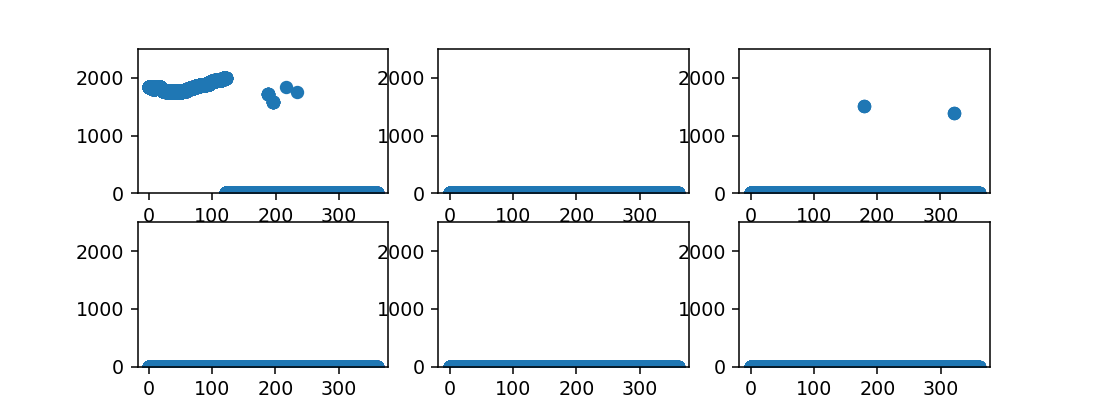

In [14]:
plt.figure(figsize=(8,3))
for i,(pilot,exp) in enumerate(containsZero):
    chunk = train_df[(train_df.pilot==pilot) & (train_df.experiment==exp)]
    plt.subplot(2,3,i+1)
    plt.scatter(chunk.time,chunk.gsr)
    plt.ylim([0,2500])

We should fill zeros with estimates. We can firstly try if we can get a non-zero mean value for the pilot and corresponding experiment and replace zeros with this value (102:CA, 102:SS). If we get all zeros in one experiment, consider use the pilot's mean value. 

We can stop 0s from affecting mean calculations by replacing them into NANs. Also, we do the same to the test dataset.

In [15]:
train_df.loc[train_df.gsr==0,'gsr']=np.nan
test_df.loc[test_df.gsr==0,'gsr']=np.nan

gsr_reference = pd.pivot_table(train_df[['gsr','event','pilot']],index='pilot',columns=['event'],aggfunc=np.mean)
gsr_reference.head()

gsr                                       
event            A            C            D            B
pilot                                                    
1       713.021729   801.846375   673.309509   860.992859
2      1095.697998  1279.048950  1225.643066  1074.893066
3       806.885376   802.571777   695.225464  1004.742981
4       880.521240   939.883728   876.848083   880.694031
5      1526.038208  1445.909668  1705.614380  1498.331055

Then we replace NAN values using estimates. 

In [16]:
for i,(pilot,exp) in enumerate(containsZero):
    chunk = train_df[(train_df.pilot==pilot) & (train_df.experiment==exp)]
    if not np.isnan(chunk.gsr).all():
        train_df.loc[chunk[np.isnan(chunk.gsr)].index,'gsr']=chunk.gsr.mean()
    else:
        train_df.loc[chunk.index,'gsr']=gsr_reference.loc[pilot].mean()

As we do not have 'event' column in test data while test data contains considerable 0s in gsr, we use mean value in training data to fill.

In [17]:
for pilot in tqdm(test_df.pilot.unique()):
    chunk = test_df[test_df.pilot==pilot]
    if (np.isnan(chunk.gsr)).any():
        test_df.loc[chunk[np.isnan(chunk.gsr)].index,'gsr']=gsr_reference.loc[pilot].mean()

### Feature Engineering

#### Signal filtering
To be honest, we are not eeg specialists, and have little domain knowledge of EEG. However, after reading essays, we realized it might be useful to filter out high-frequency signals, which might be random noise. To filter signals, we should use scipy.signal package. We suspect existence of sweat artifact but cannot confirm this based on our knowledge.

In [18]:
from scipy import signal

Let's try it out first! For illustration purposes, we pick up the first 500 rows of eeg_fp1 data from pilot No.1 and experiment CA.

<IPython.core.display.Javascript object>


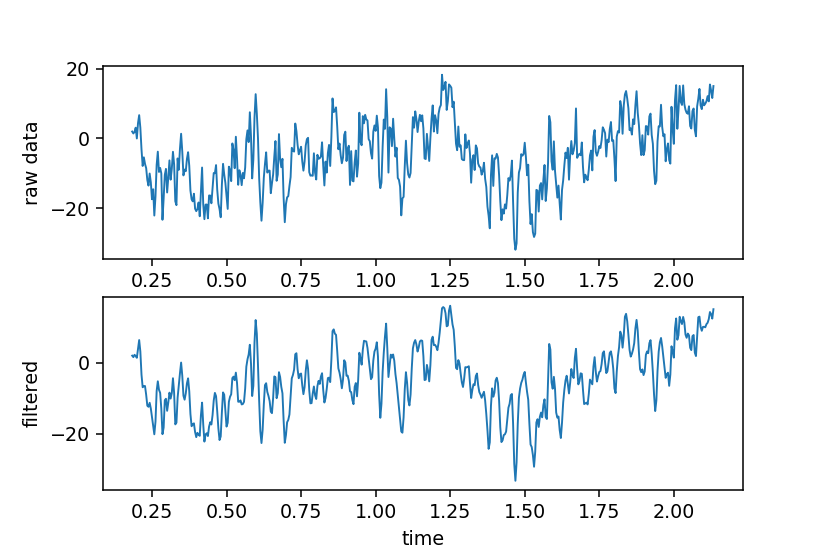

In [19]:
signal_example=chunk_sorted[chunk_sorted.experiment=='CA'].iloc[0:500]

plt.figure(figsize=(6,4))
d = signal_example.eeg_fp1
b, a = signal.butter(2,0.6) 

y = signal.filtfilt(b, a, d, padlen=150)

plt.subplot(2,1,1)
sns.lineplot(signal_example.time,d,hue=signal_example.event,linewidth=1)
plt.gca().get_legend().remove()
plt.ylabel('raw data')

plt.subplot(2,1,2)
sns.lineplot(signal_example.time,y,hue=signal_example.event,linewidth=1)
plt.gca().get_legend().remove()
plt.ylabel('filtered');


Much clearer! Now let's apply this filter to all EEG features.

In [20]:
eeg_features = ["eeg_fp1", "eeg_f7", "eeg_f8", "eeg_t4", "eeg_t6", "eeg_t5", "eeg_t3", "eeg_fp2", "eeg_o1", "eeg_p3", "eeg_pz", "eeg_f3", "eeg_fz", "eeg_f4", "eeg_c4", "eeg_p4", "eeg_poz", "eeg_c3", "eeg_cz", "eeg_o2"]


def signal_filter(df):
    for pilot in tqdm(df.pilot.unique()):
        for exp in df[df.pilot==pilot].experiment.unique():
            chunk = df[(df.pilot==pilot) & (df.experiment==exp)].sort_values(by='time')
            for eeg in eeg_features:
                df.loc[chunk.index,eeg]=pd.Series(data=signal.filtfilt(b, a, chunk[eeg], padlen=150),index=chunk.index,dtype='float32')
signal_filter(train_df)
signal_filter(test_df)

#### Group Feature Extraction

We assigned a groupid for each row. We can therefore calculate some features out of groups, such as min, max, standard deviation and mean, which might help model predict more accurately. If we assign groups with large interval, we risk new features being too general to catch important details. Inversely, if we have lots of groups, it is likely we end up overfitting after a looooooooooog time of calculation.

WARNING: This code takes a VERY long time (possible days and nights) to run when we have small interval (as we will have lots of groups to deal with).

In [23]:
features_to_group=['gsr','r','ecg']
grouped_features=['_grouped_'+e for e in ['max','min','std','mean']]
new_features=[e+f for e in features_to_group for f in grouped_features]

def extract_group_feature(df):
    for nfeature in new_features:
        df[nfeature]=np.nan
    
    for gid in tqdm(df.groupid.unique()):
        chunk=df[df.groupid==gid]
        for feature in features_to_group:
            max_value = chunk[feature].max()
            min_value = chunk[feature].min()
            std_value = chunk[feature].std()
            mean_value = chunk[feature].mean()

            if np.isnan(std_value):
                std_value = 0

            df.loc[chunk.index,[feature+e for e in grouped_features]]=[max_value,min_value,std_value,mean_value]
extract_group_feature(train_df)
extract_group_feature(test_df)

#### Normalization

We finally normalize our data. Remember to use RobustScaler to deal with outliers and normalize on pilot level and apply scaler trained with training data to normalize test data to avoid data leakage.

In [24]:
all_features = eeg_features+["ecg", "r", "gsr"]+new_features
from sklearn.preprocessing import RobustScaler

for pilot in tqdm(train_df.pilot.unique()):
    scaler = RobustScaler()
    chunk = train_df.loc[train_df.pilot==pilot,all_features]
    train_df.loc[chunk.index,all_features]=scaler.fit_transform(chunk).astype('float32')
    
    test_chunk = test_df.loc[test_df.pilot==pilot,all_features]
    test_df.loc[test_chunk.index,all_features]=scaler.transform(test_chunk).astype('float32')

#### Memory Optimization

LightGBM takes a numpy matrix with dtype float32. If we are parsing a dataframe, or a matrix with dtype other than float32, LightGBM will make a copy of our data and try converting it to float32. During this process, memory usage can peak twice the size of input dataset, which can result in a memory error. Hence, we should make adjustments to avoid memory waste.

In [25]:
try:
test_id = test_df.id
test_df.drop(columns=['id', 'crew', 'experiment', 'time', 'seat','pilot','groupid'],inplace=True)
except:
    pass
for column in test_df.columns:
    test_df[column] = test_df[column].astype('float32')

In [28]:
assert(test_df.values.dtype=='float32')

This part is used for environment saving/loading so that we do not have to run all above and wait for 24hrs like idiots.
By the way, pickle files are far faster to read and save and more space-efficient than csv files.

In [34]:
train_df.to_pickle('train.pkl')
test_df.to_pickle('test.pkl')

train_df=pd.read_pickle('train.pkl')
test_df=pd.read_pickle('test.pkl')

### Model Training
To evaluate model performance, we should split data into training set and validation set. As mentioned above, we are doing this on a coarser level.


In [35]:
dic = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
X_train,X_val,y_train,y_val = train_test_split_group(train_df.drop('event',axis=1)[all_features],train_df.event,random_state=140,grouping_reference=train_df.groupid,train_size=0.8)  
#train_test_split(train_df.drop('event',axis=1)[all_features],train_df.event.apply(lambda x:dic.get(x)), test_size=0.2, random_state=420)

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


From previous visuals we know we have an imbalanced dataset. We can apply SMOTE to compensate. Now we can unload train_df to save memory.

In [ ]:
from imblearn.over_sampling import SMOTE
train_df=None
gc.collect()

X_train, y_train = SMOTE(n_jobs=4).fit_resample(X_train, y_train.ravel())

We start with two LGBMClassifers of different learning rate.

In [ ]:
params1 = {
    "objective" : "multiclass",
    "num_class": 4,
    "metric" : "multi_error",
    "num_leaves" : 40,
    "min_child_weight" : 50,
    "learning_rate" : 0.1,
    "n_estimators":1000,
    "bagging_fraction" : 0.7,
    "feature_fraction" : 0.7,
    "bagging_seed" : 420,
    "verbosity" : -1
}
model1 = lgb.LGBMClassifier(**params1,early_stopping_rounds=50)
model1.fit(X_train,y_train,eval_set=[(X_val,y_val)],eval_metric='multi_error',verbose=100)

params2 = {
    "objective" : "multiclass",
    "num_class": 4,
    "metric" : "multi_error",
    "num_leaves" : 40,
    "learning_rate" : 0.07,
    "n_estimators":1000,
    "verbosity" : -1
}

model2 = lgb.LGBMClassifier(**params2,early_stopping_rounds=50)
model2.fit(X_train,y_train,eval_set=[(X_val,y_val)],eval_metric='multi_error',verbose=100);

This cell is used for model loading/saving. Useful when we would like to save our work.

In [ ]:
from joblib import load,dump
dump(model1,'model1.joblib')
dump(model2,'model2.joblib')

#model1=load('model1.joblib')
#model2=load('model2.joblib')

Now it is time to evaluate our models!

In [ ]:
pred_val1 = model1.predict(X_val, num_iteration=model1.best_iteration_)
pred_val2 = model2.predict(X_val, num_iteration=model2.best_iteration_)

This plotting funtion is from Theo's kernel which I found really useful.

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes, title='Confusion matrix', normalize=False, cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fmt = '.4f' if normalize else 'd'

    fig, ax = plt.subplots(figsize=(7, 5))
    ax.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=15)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = (cm.max()+cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size=12)
    plt.xlabel('Predicted label', size=12)

conf_mat_val = confusion_matrix(y_val.values,pred_val1)
plot_confusion_matrix(conf_mat_val, ["A", "B", "C", "D"], title='CM Model 1', normalize=True)

conf_mat_val = confusion_matrix(y_val.values,pred_val2)
plot_confusion_matrix(conf_mat_val, ["A", "B", "C", "D"], title='CM Model 2', normalize=True)

Because we use 240-sec fragments in this kernel, and B, D events last only several seconds at most, we are missing a large amount of useful group-level information, which means we should lower the interval. However, as discussed previously, low interval value leads to heavier computational burden than Kaggle allows. Typically suggested interval is 1 or 2 seconds.

#### Thanks for reading! Any feedback is helpful!